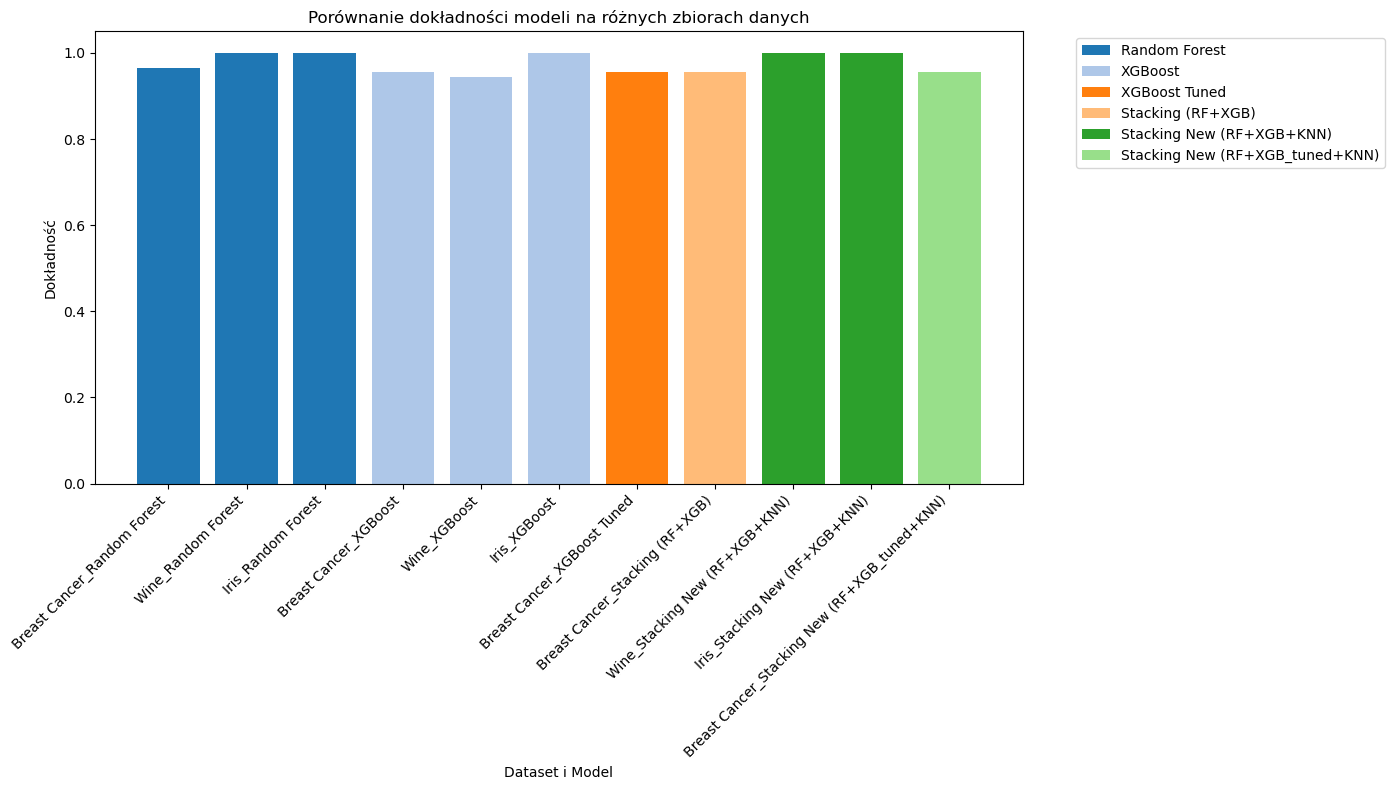


DOKŁADNE WYNIKI DOKŁADNOŚCI:

Breast Cancer:
------------------------------
Random Forest                            | 0.9649
XGBoost                                  | 0.9561
XGBoost Tuned                            | 0.9561
Stacking (RF+XGB)                        | 0.9561
Stacking New (RF+XGB_tuned+KNN)          | 0.9561

Wine:
------------------------------
Random Forest                            | 1.0000
XGBoost                                  | 0.9444
Stacking New (RF+XGB+KNN)                | 1.0000

Iris:
------------------------------
Random Forest                            | 1.0000
XGBoost                                  | 1.0000
Stacking New (RF+XGB+KNN)                | 1.0000


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer, load_wine, load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd

# Funkcja do ładowania i podziału danych
def load_and_split_dataset(dataset_loader):
    data = dataset_loader()
    X, y = data.data, data.target
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Analiza dla breast_cancer
X_train_bc, X_test_bc, y_train_bc, y_test_bc = load_and_split_dataset(load_breast_cancer)

# Zadanie 1: Porównanie modeli
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
stacking_base = [('rf', rf), ('xgb', xgb)]
stacking = StackingClassifier(estimators=stacking_base, final_estimator=LogisticRegression())

models_bc = {
    'Random Forest': rf,
    'XGBoost': xgb,
    'Stacking (RF+XGB)': stacking
}

results_bc = {}
for name, model in models_bc.items():
    model.fit(X_train_bc, y_train_bc)
    y_pred = model.predict(X_test_bc)
    results_bc[name] = accuracy_score(y_test_bc, y_pred)

# Zadanie 2: Strojenie XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_bc, y_train_bc)

best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train_bc, y_train_bc)
results_bc['XGBoost Tuned'] = accuracy_score(y_test_bc, best_xgb.predict(X_test_bc))

# Zadanie 3: Nowy model w Stackingu
knn = KNeighborsClassifier()
stacking_new_base = [('rf', rf), ('xgb_tuned', best_xgb), ('knn', knn)]
stacking_new = StackingClassifier(stacking_new_base, LogisticRegression())
stacking_new.fit(X_train_bc, y_train_bc)
results_bc['Stacking New (RF+XGB_tuned+KNN)'] = accuracy_score(y_test_bc, stacking_new.predict(X_test_bc))

# Testowanie na innych zbiorach (Wine, Iris)
datasets = {
    'Wine': load_wine,
    'Iris': load_iris
}

results = {'Breast Cancer': results_bc, 'Wine': {}, 'Iris': {}}

for ds_name, loader in datasets.items():
    X_train, X_test, y_train, y_test = load_and_split_dataset(loader)
    
    rf = RandomForestClassifier(random_state=42)
    xgb = XGBClassifier(random_state=42)
    knn = KNeighborsClassifier()
    
    stacking_new = StackingClassifier(
        [('rf', rf), ('xgb', xgb), ('knn', knn)],
        LogisticRegression()
    )
    
    models = {
        'Random Forest': rf,
        'XGBoost': xgb,
        'Stacking New (RF+XGB+KNN)': stacking_new
    }
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        results[ds_name][name] = accuracy_score(y_test, model.predict(X_test))

# Przygotowanie danych do wykresu
df_list = []
for dataset in results:
    if dataset == 'Breast Cancer':
        for model, acc in results[dataset].items():
            df_list.append({'Dataset': dataset, 'Model': model, 'Accuracy': acc})
    else:
        for model in ['Random Forest', 'XGBoost', 'Stacking New (RF+XGB+KNN)']:
            df_list.append({'Dataset': dataset, 'Model': model, 'Accuracy': results[dataset][model]})

df = pd.DataFrame(df_list)

# Wykres
plt.figure(figsize=(14, 8))
models_order = ['Random Forest', 'XGBoost', 'XGBoost Tuned', 'Stacking (RF+XGB)', 'Stacking New (RF+XGB+KNN)', 'Stacking New (RF+XGB_tuned+KNN)']
colors = plt.cm.tab20.colors

for i, model in enumerate(models_order):
    if model in df['Model'].unique():
        subset = df[df['Model'] == model]
        plt.bar(subset['Dataset'] + "_" + model, subset['Accuracy'], color=colors[i], label=model)

plt.xticks(rotation=45, ha='right')
plt.xlabel('Dataset i Model')
plt.ylabel('Dokładność')
plt.title('Porównanie dokładności modeli na różnych zbiorach danych')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Nowa sekcja: wypisanie wyników
print("\nDOKŁADNE WYNIKI DOKŁADNOŚCI:")
print("="*50)

for dataset in ['Breast Cancer', 'Wine', 'Iris']:
    print(f"\n{dataset}:")
    print("-"*30)
    
    # Filtrujemy wyniki dla danego zbioru danych
    subset = df[df['Dataset'] == dataset]
    
    # Sortujemy zgodnie z kolejnością models_order
    subset = subset.sort_values(by='Model', 
                              key=lambda x: x.map({v:i for i,v in enumerate(models_order)}))
    
    # Wypisujemy w formie tabeli
    for _, row in subset.iterrows():
        print(f"{row['Model']:40} | {row['Accuracy']:.4f}")